# Statistical Machine Learning Exercise Sheet 9
- Laura Haege
- Philipp Noel von Bachmann, Matrikelnummer: 4116220

## Exercise 16
### (a)
First we compute the derivative of the loss with respect to $a$ and $c$.
\begin{align*}
  \frac{\partial}{\partial c} L(f)
  & = \frac{\partial}{\partial c} \sum_{i=1}^n \gamma_i (Y_i - f(X_i))^2 \\
  & = \sum_{i=1}^n \gamma_i \frac{\partial}{\partial c} (Y_i - f(X_i))^2 \\
  & = \sum_{i=1}^n \gamma_i 2 (Y_i - f(X_i)) \frac{\partial}{\partial c} (Y_i - f(X_i))\\
  & = \sum_{i=1}^n -\gamma_i 2 (Y_i - f(X_i))\\
\end{align*}

\begin{align*}
  \frac{\partial}{\partial a} L(f)
  & = \frac{\partial}{\partial a} \sum_{i=1}^n \gamma_i (Y_i - f(X_i))^2 \\
  & = \sum_{i=1}^n \gamma_i \frac{\partial}{\partial a} (Y_i - f(X_i))^2 \\
  & = \sum_{i=1}^n \gamma_i 2 (Y_i - f(X_i)) \frac{\partial}{\partial a} (Y_i - f(X_i))\\
  & = \sum_{i=1}^n -\gamma_i 2 (Y_i - f(X_i)) \mathbb{1}_{\langle w, X_i\rangle +b>0}\\
\end{align*}

Now we can set the gradient to 0 and solve both equations for a:


\begin{align*}
  0 & = \sum_{i=1}^n \gamma_i 2 (Y_i - f(X_i)) \mathbb{1}_{\langle w, X_i\rangle +b>0}\\
  \Leftrightarrow a &= \frac{\sum_{i=1}^n   \gamma_i  (Y_i-c)}{\sum_{i=1}^n   \gamma_i  \mathbb{1}_{\langle w, X_i\rangle +b>0}} \\
\end{align*}

and 
\begin{align*}
  0 &= \sum_{i=1}^n -\gamma_i 2 (Y_i - f(X_i)) \mathbb{1}_{\langle w, X_i\rangle +b>0}\\
  \Leftrightarrow a &= \frac{\sum_{i=1}^n   \gamma_i \mathbb{1}_{\langle w, X_i\rangle +b>0} (Y_i-c)}{\sum_{i=1}^n   \gamma_i  \mathbb{1}_{\langle w, X_i\rangle +b>0}}
\end{align*}

Now set a equal and solve for c:
\begin{align*}
    \frac{\sum_{i=1}^n   \gamma_i  (Y_i+c)}{\sum_{i=1}^n   \gamma_i  \mathbb{1}_{\langle w, X_i\rangle +b>0}}
    &= \frac{\sum_{i=1}^n   \gamma_i \mathbb{1}_{\langle w, X_i\rangle +b>0} (Y_i+c)}{\sum_{i=1}^n   \gamma_i  \mathbb{1}_{\langle w, X_i\rangle +b>0}}\\
    \implies \sum_{i=1}^n   \gamma_i  (Y_i+c)
    &= \sum_{i=1}^n   \gamma_i \mathbb{1}_{\langle w, X_i\rangle +b>0} (Y_i+c)\\
    \implies c &= \frac{\sum_{i=1}^n   \gamma_i Y_i (1 - \mathbb{1}_{\langle w, X_i\rangle +b>0})}
    {\sum_{i=1}^n   \gamma_i(1 - \mathbb{1}_{\langle w, X_i\rangle +b>0})}
\end{align*}


### (b)

In [1]:
import numpy as np
from tqdm import tqdm

def FitStump(X, Y, w, gamma):
    # first sort everything so we can use cumsum, and set b values
    # Note: we would have to add small epsilon to b values to make prediction >0, but we can also just use >=0 without epsilon,
    # then we have to make no assumption how far datapoints lie away from each other
    prediction = X @ w
    sorting = np.flip(np.argsort(prediction))
    b = - prediction[sorting]
    b = np.append(b[0]+ np.sign(b[0]) * 1, b)
    gamma_sorted = gamma[sorting]
    Y_sorted = Y[sorting]

    # now compute a and c for all values of b
    c_upper =  np.sum(gamma_sorted * Y_sorted) - np.append(0, np.cumsum(gamma_sorted * Y_sorted))
    c_lower = np.sum(gamma_sorted) - np.append(0, np.cumsum(gamma_sorted))
    c = c_upper / np.maximum(c_lower, 1e-5)
    a = np.sum(gamma * (Y - c.T), axis=0) / np.maximum(np.append(0, np.cumsum(gamma_sorted)), 1e-5)

    # compute the resulting errors and take the smallest one
    errors = np.linalg.norm(gamma_sorted * (Y_sorted - (np.add.outer(prediction[sorting] , b.T) >= 0) * a.T + c.T), axis=0)
    min_index = np.argmin(errors)
    return a[min_index], b[min_index], c[min_index], errors[min_index]


### (c)

In [2]:
def GentleBoost(X, Y, k):
    dim = X.shape[1]
    # init gamma uniformly, prediction with zeros
    gamma = np.ones((X.shape[0], 1))/X.shape[0]
    predictions = np.zeros_like(Y, dtype=float)
    a_s = np.zeros(k)
    b_s = np.zeros(k)
    c_s = np.zeros(k)
    w_s = np.zeros((dim, k))
    training_errors = []
    for episode in tqdm(range(k)):
        # choose random w and calculate a,b,c
        w = np.random.randn(dim)
        w = w/np.linalg.norm(w)
        a,b,c,error = FitStump(X, Y, w, gamma)
        a_s[episode] = a
        b_s[episode] = b
        c_s[episode] = c
        w_s[:, episode] = w
        current_prediction =  a *(((X @ w) + b) >= 0) + c
        # recalculate gamma for next episode
        gamma = gamma * np.expand_dims(np.exp(- np.squeeze(Y) * current_prediction), axis=1)
        gamma = gamma/np.sum(gamma)
        # calculate combined prediction and print their error
        predictions += np.expand_dims(current_prediction, axis=1)
        current_training_error = np.linalg.norm(gamma * (Y - predictions/(episode+1)))
        training_errors.append(current_training_error)
        if (episode % 100) ==0:
            print(f"The training error is:{current_training_error}")

    return w_s, a_s, b_s, c_s, training_errors

### (d)

In [3]:
data = np.load("USPS_data.npy", allow_pickle=True).item()
X_train = data["Xtrain"]
Y_train = data["Ytrain"]
X_train = X_train[np.where(Y_train < 2)[0], :]
Y_train = Y_train[np.where(Y_train < 2)[0]]
X_test = data["Xtest"]
Y_test = data["Ytest"]
X_test = X_test[np.where(Y_train < 2)[0], :]
Y_test = Y_test[np.where(Y_train < 2)[0]]

In [4]:
w, a, b, c, training_errors = GentleBoost(X_train, Y_train, 1000)

  1%|          | 7/1000 [00:00<00:34, 28.87it/s]

The training error is:0.030399633413629733


 10%|█         | 105/1000 [00:03<00:31, 28.67it/s]

The training error is:0.00030098646944210297


 21%|██        | 207/1000 [00:06<00:17, 45.53it/s]

The training error is:0.00015124195728188623


 31%|███       | 307/1000 [00:08<00:15, 44.47it/s]

The training error is:0.00010099545984604252


 41%|████      | 407/1000 [00:10<00:13, 42.81it/s]

The training error is:7.580955963505505e-05


 50%|█████     | 505/1000 [00:13<00:11, 43.63it/s]

The training error is:6.0677911005302833e-05


 60%|██████    | 605/1000 [00:15<00:09, 43.63it/s]

The training error is:5.058175276814892e-05


 71%|███████   | 710/1000 [00:18<00:06, 43.17it/s]

The training error is:4.336609616784288e-05


 81%|████████  | 807/1000 [00:20<00:04, 41.89it/s]

The training error is:3.795210164002435e-05


 91%|█████████ | 908/1000 [00:22<00:02, 45.59it/s]

The training error is:3.373988170217523e-05


100%|██████████| 1000/1000 [00:25<00:00, 39.69it/s]


In [5]:
def compute_test_errors(X, Y, w, a, b, c):
    predictions = a *(((X @ w) + b) >= 0) + c
    predictions = np.cumsum(predictions, axis=0)/np.arange(1, predictions.shape[1] + 1, 1).T
    test_errors = np.linalg.norm(Y - predictions, axis=0)
    return test_errors

In [6]:
test_errors = compute_test_errors(X_test, Y_test, w, a, b, c)

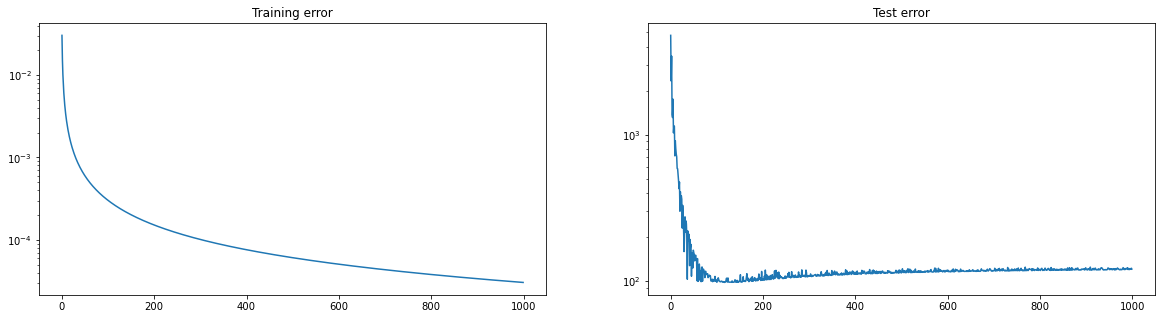

In [7]:
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(training_errors)
ax1.set_title("Training error")
ax1.set_yscale("log")
ax2.plot(test_errors)
ax2.set_yscale("log")
ax2.set_title("Test error");

We can see that the test error only increases moderatly again which means the generalization error only increases moderatly while still improving the training error.

### (e)

In [8]:
data = np.load("USPS_data.npy", allow_pickle=True).item()
prediction_class = 1
X_train = data["Xtrain"]
Y_train = data["Ytrain"]
Y_train[np.where(Y_train != prediction_class)[0]] = 0
X_test = data["Xtest"]
Y_test = data["Ytest"]
Y_test[np.where(Y_test != prediction_class)[0]] = 0

In [9]:
w, a, b, c, training_errors = GentleBoost(X_train, Y_train, 1000)

  0%|          | 2/1000 [00:00<03:02,  5.47it/s]

The training error is:0.0464860117107709


 10%|█         | 102/1000 [00:16<02:17,  6.54it/s]

The training error is:0.00046025754169097994


 20%|██        | 202/1000 [00:32<02:08,  6.23it/s]

The training error is:0.0002312736901034793


 30%|███       | 302/1000 [00:47<01:46,  6.55it/s]

The training error is:0.00015443857711228934


 40%|████      | 402/1000 [01:06<02:02,  4.89it/s]

The training error is:0.00011592521623640656


 50%|█████     | 502/1000 [01:26<01:47,  4.64it/s]

The training error is:9.278645052055533e-05


 60%|██████    | 601/1000 [01:48<01:19,  5.03it/s]

The training error is:7.734777322928993e-05


 70%|███████   | 702/1000 [02:09<01:00,  4.89it/s]

The training error is:6.631385408103062e-05


 80%|████████  | 802/1000 [02:33<00:45,  4.35it/s]

The training error is:5.803497092485048e-05


 90%|█████████ | 901/1000 [03:00<00:23,  4.17it/s]

The training error is:5.159379768124634e-05


100%|██████████| 1000/1000 [03:20<00:00,  4.98it/s]


In [10]:
test_errors = compute_test_errors(X_test, Y_test, w, a, b, c)

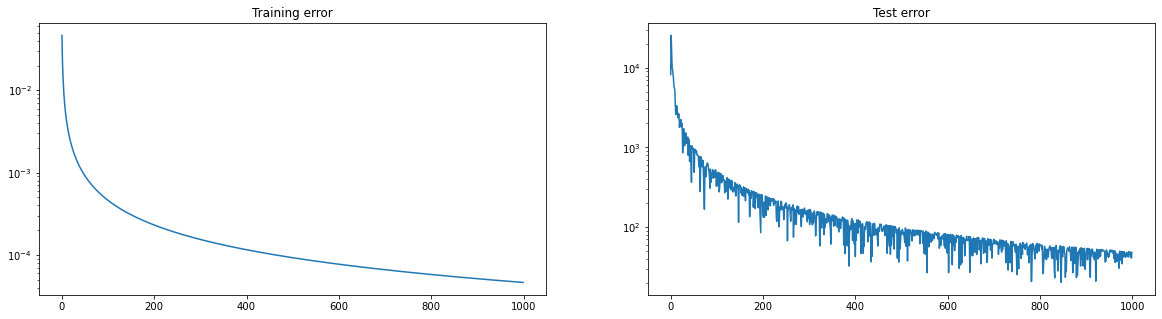

In [12]:
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(training_errors)
ax1.set_title("Training error")
ax1.set_yscale("log")
ax2.plot(test_errors)
ax2.set_yscale("log")
ax2.set_title("Test error");

## Exercise 17
### (a)
We can rewrite $P(X_{n+1} < X_1) = P(X_1 - X_{n+1} > 0)$ and we can write
$X_1 - X_{n+1} = A \begin{pmatrix}X_1\\ X_{n+1}\end{pmatrix} =
\begin{pmatrix}1 & -1\end{pmatrix} \begin{pmatrix}X_1\\
X_{n+1}\end{pmatrix}$.

We know that $\begin{pmatrix}X_1\\
X_{n+1}\end{pmatrix} \sim \mathcal{N}(\begin{pmatrix}0 \\
\mu\end{pmatrix}), \sigma^2 I) \implies A
\begin{pmatrix}X_1\\X_{n+1}\end{pmatrix} = X_1 - X_{n+1} \sim N(\mu, 2 \sigma^2)$

Now it follows that 
\begin{align}
    P(X_1 - X_{n+1} > 0)
    & = \int_0^{\infty} \mathcal{N}(x,\mu, 2\sigma^2) dx\\
    & = \int_0^{\infty} \frac{1}{\sqrt{2 \pi 2 \sigma^2}} exp(-\frac{(x- \mu)^2}{2 2 \sigma^2})\\
    & = \int_0^{\infty} \frac{1}{2 \sqrt{\pi} \sigma} exp(-\frac{(x- \mu)^2}{4 \sigma^2})\\
    & = \int_0^{\infty} \frac{1}{2 \sqrt{\pi} \sigma} exp(-\frac{(x- \mu)^2}{(2\sigma)^2})\\
    & = \frac{1}{2 \sqrt{\pi} \sigma} \int_0^{\infty}  exp(-(\frac{(x- \mu)}{(2\sigma)})^2)\\
\end{align}

### (b)
\begin{align}
    P(\max_i X_i < X_{n+1}) 
    &= P(\bigcap_i X_i < X_{n+1})\\
    &= 1 - P(\overline{\bigcap_i X_i < X_{n+1}})\\
    &= 1 - P(\bigcup_i X_{n+1} > X_i) \\
    &\geq 1 - \sum_i P(X_{n+1} > X_i) \\
    &= 1 - n P(X_{n+1} \leq X_1)
\end{align}
Where the last step follows from the $X_i$ beeing iid. Technically, the
couter-event of $X_i < X_n$ is $X_n \leq X_i$ but since $P(X_i = X_n)$ is a
single point and thus has probability 0 in an continuous space, we can drop
the equal.